# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Axel Leonardo Fernandez Albarran

**Professor**: Pablo Camarillo Ramirez

# Introduction

**Data Set**: https://www.kaggle.com/datasets/rishabhrajsharma/cityride-dataset-rides-data-drivers-data?select=Rides_Data.csv

Urban ride-sharing platforms generate large volumes of trip and driver data every day. Analyzing this information helps improve pricing, demand prediction, and operational efficiency.

This project uses the CityRide dataset, which contains details about rides and drivers, to build a batch data processing pipeline with Apache Spark. The goal is to clean, transform, and persist the data to uncover patterns in ride demand, driver performance, and fare distribution, supporting smarter urban mobility decisions.

# Dataset

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on storage solutions with PosgreSQL") \
    .master("spark://spark-master:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")


25/10/26 00:05:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/26 00:05:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
!pwd
!ls /opt/spark/work-dir/data/final_project/

/opt/spark/work-dir
'Cityride Drivers Data.csv'  'Cityride Rides Data.csv'
'Cityride Drivers Data.csv'  'Cityride Rides Data.csv'


In [3]:
from axel_fernandez.spark_utils import SparkUtils

# Esquema de ambos datasets 
drivers_schema_columns = [
    ("Driver_ID", "int"),
    ("Name", "string"),
    ("Age", "int"),
    ("City", "string"),
    ("Experience_Years", "int"),
    ("Average_Rating", "double"),
    ("Active_Status", "string")
]

rides_schema_columns = [
    ("Ride_ID", "int"),
    ("Driver_ID", "int"),
    ("City", "string"),
    ("Date", "string"),      
    ("Distance_km", "double"),
    ("Duration_min", "int"),
    ("Fare", "double"),
    ("Rating", "double"),
    ("Promo_Code", "string")
]

schema_drivers = SparkUtils.generate_schema(drivers_schema_columns)
schema_rides = SparkUtils.generate_schema(rides_schema_columns)

drivers_df = spark.read.schema(schema_drivers).option("header", True)\
    .csv("/opt/spark/work-dir/data/final_project/Cityride Drivers Data.csv")

rides_df = spark.read.schema(schema_rides).option("header", True)\
    .csv("/opt/spark/work-dir/data/final_project/Cityride Rides Data.csv")


# Transformations and Actions

In [ ]:
from pyspark.sql.functions import col, trim, lower, when, to_date, lit, ceil


# Limpiamos ambos datasets 
# Solamente eliminamos duplicados, filtramos por si acaso y renombramos columnas
drivers_clean_df = (
    drivers_df
    .dropDuplicates(["Driver_ID"])
    .withColumn("Name", trim(col("Name")))
    .withColumn("City", trim(col("City")))
    .filter(col("Driver_ID").isNotNull() & col("Name").isNotNull())
    .withColumnRenamed("Driver_ID", "driver_id")
    .withColumnRenamed("Name", "driver_name")
    .withColumnRenamed("Age", "driver_age")
    .withColumnRenamed("City", "driver_city")
    .withColumnRenamed("Experience_Years", "driver_experience_years")
    .withColumnRenamed("Average_Rating", "driver_avg_rating")
    .withColumnRenamed("Active_Status", "driver_active_status")
)

# Eliminamos rides duplicados, limpiamos columnas, filtramos valores inválidos y renombramos columnas
rides_clean_df = (
    rides_df
    .dropDuplicates(["Ride_ID"])
    .withColumn("City", trim(col("City")))
    .withColumn("Date_raw", trim(col("Date")))
    .withColumn("Ride_Date", to_date(col("Date_raw"), "M/d/yyyy"))
    .withColumn("Promo_Code", when((col("Promo_Code").isNull()) | (trim(col("Promo_Code")) == ""), lit("NO_PROMO"))
                              .otherwise(trim(col("Promo_Code"))))
    .filter(col("Ride_ID").isNotNull() & col("Driver_ID").isNotNull() & col("Ride_Date").isNotNull())
    .filter((col("Distance_km") >= 0) & (col("Duration_min") >= 0) & (col("Fare") >= 0)) 
    .filter(col("Rating").between(0.0, 5.0))
    .withColumn("Rating", ceil(col("Rating")).cast("int"))
    .drop("Date", "Date_raw")
    .withColumnRenamed("Ride_ID", "ride_id")
    .withColumnRenamed("Driver_ID", "driver_id")
    .withColumnRenamed("City", "city_ride")
    .withColumnRenamed("Ride_Date", "ride_date")
    .withColumnRenamed("Distance_km", "distance_km")
    .withColumnRenamed("Duration_min", "duration_min")
    .withColumnRenamed("Fare", "fare")
    .withColumnRenamed("Rating", "rating")
    .withColumnRenamed("Promo_Code", "promo_code")
)

In [ ]:
# Unimos ambos DataFrames y seleccionamos las columnas deseadas para guardarlo en PostgreSQL
rides_with_drivers_df = rides_clean_df.join(
    drivers_clean_df,
    on="driver_id",
    how="left"
).select("driver_name","driver_age","city_ride","ride_date","distance_km","duration_min","fare","rating","promo_code")


# Persistence Data

Se eligió PostgreSQL porque los datos son tabulares y el objetivo principal es análisis y agregaciones sobre viajes donde la información del conductor actúa solo como lookup

In [ ]:
# Configuración de la conexión a PostgreSQL
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "rides_with_drivers"

db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

In [ ]:
# Guardamos el DataFrame resultante en la tabla 'rides_with_drivers' de PostgreSQL
rides_with_drivers_df.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

In [10]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "rides_with_drivers"
db_properties = {"user": "postgres", "password": "Admin@1234", "driver": "org.postgresql.Driver"}

# leer tabla desde Postgres
rides_df = spark.read.jdbc(url=jdbc_url, table=table_name, properties=db_properties)
rides_df.createOrReplaceTempView("rides")

# 1) promedio de fare y conteo de viajes por código promocional que inicie con 'WELCOME'
q1 = spark.sql("""
SELECT lower(promo_code) AS promo_code,
       AVG(fare) AS avg_fare,
       COUNT(*) AS rides_count
FROM rides
WHERE lower(promo_code) LIKE 'welcome%'
GROUP BY lower(promo_code)
""")
q1.show(truncate=False)

# 2) Conductores con mayor promedio de fare por km recorrido
q2 = spark.sql("""
SELECT
    driver_name,
    round(SUM(distance_km), 2) AS total_km,
    round(SUM(fare), 2) AS total_fare,
    COUNT(*) AS rides_count,
    round(SUM(fare) / NULLIF(SUM(distance_km), 0), 2) AS avg_fare_per_km
FROM rides
GROUP BY driver_name
ORDER BY avg_fare_per_km DESC
LIMIT 10
""")
q2.show(truncate=False)



+----------+----------------+-----------+
|promo_code|avg_fare        |rides_count|
+----------+----------------+-----------+
|welcome5  |47.9923651452282|241        |
+----------+----------------+-----------+

+-----------------+--------+----------+-----------+---------------+
|driver_name      |total_km|total_fare|rides_count|avg_fare_per_km|
+-----------------+--------+----------+-----------+---------------+
|Eric Gray        |128.9   |327.84    |5          |2.54           |
|Jeffery Williams |225.1   |569.5     |9          |2.53           |
|Heather Meyer    |102.1   |250.06    |5          |2.45           |
|David Craig      |206.5   |474.13    |8          |2.3            |
|Frank Mitchell   |166.8   |381.71    |5          |2.29           |
|Jason Adams      |231.3   |522.56    |7          |2.26           |
|Lawrence Santiago|286.3   |626.94    |9          |2.19           |
|Barbara Bryant   |198.0   |432.45    |8          |2.18           |
|William Richards |130.0   |281.11    |7 

# DAG

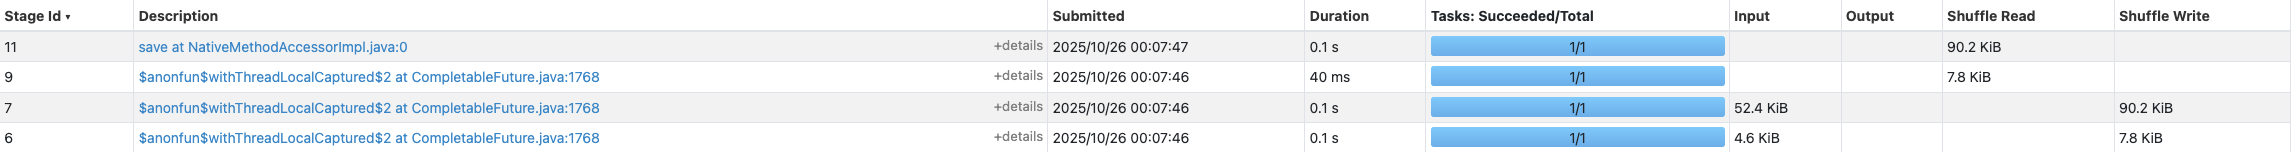

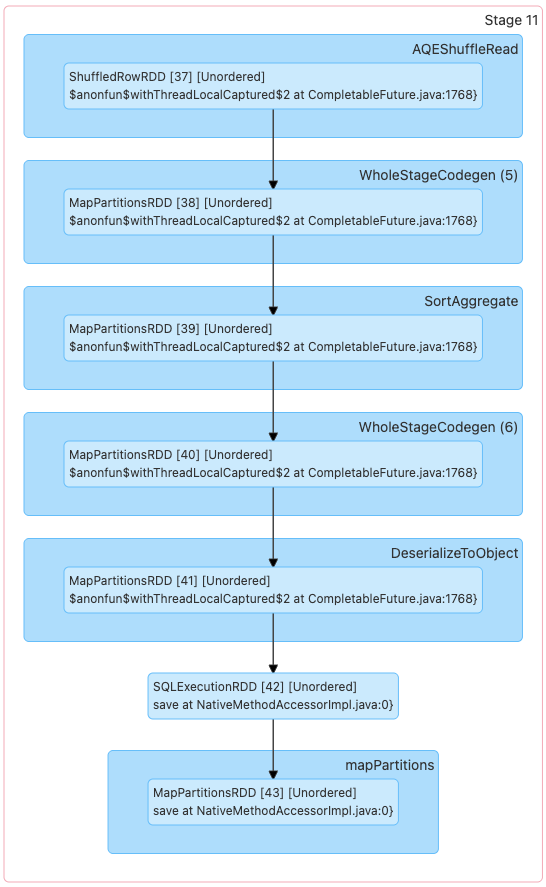